In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from sklearn import preprocessing
from scipy.stats import skew
from scipy.stats import boxcox

# Additional scklearn functions
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV   
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

# Classifiers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
rcParams['figure.figsize'] = 12, 4


/home/itachi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/itachi/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data = pd.read_csv("Training_Dataset.csv")

In [3]:
data.drop(['mvar1','mvar12'], axis=1, inplace=True)

data['card_extension'] = data['mvar46'] + 2*data['mvar47'] + 3*data['mvar48']
data.drop(['mvar46', 'mvar47', 'mvar48'], axis=1, inplace=True)

data['card_acceptance'] = data['mvar49'] + 2*data['mvar50'] + 3*data['mvar51']
data.drop(['mvar49', 'mvar50', 'mvar51'], axis=1, inplace=True)

In [4]:
y_extension = data['card_extension']
y_acceptance = data['card_acceptance']

In [5]:
def is_zero(s):
    return s < 1

var3 = data.pivot_table(values=["mvar3"], index=["mvar2","mvar4","mvar14",'card_extension',"mvar15"], aggfunc=np.mean)
var9 = data.pivot_table(values=["mvar9"], index=["mvar2","mvar4","mvar14",'card_extension',"mvar15"], aggfunc=np.mean)

for i,row in data.loc[is_zero(data['mvar3']),:].iterrows():
    ind = tuple([row['mvar2'],row['mvar4'],row['mvar14'],row['card_extension']])
    data.loc[i,'mvar3'] = var3.loc[ind].values[0]
    
for i,row in data.loc[is_zero(data['mvar9']),:].iterrows():
    ind = tuple([row['mvar2'],row['mvar4'],row['mvar14'],row['card_extension']])
    data.loc[i,'mvar9'] = var9.loc[ind].values[0]


In [6]:
data.drop(['cm_key','card_extension','card_acceptance'], axis=1, inplace=True)

In [7]:
def transformation_plot(var, log_multiply, cbrt_sum, boxcox_var):
    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 16,
            }
    print("feature : ",var.name)
    plt.figure(figsize=(12, 12))
    plt.subplot(411)
    plt.title('Without transformation')
    simple = var
    skness = skew(simple)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness),  fontdict=font)
    plt.hist(simple)


    plt.subplot(412) # equivalent to: plt.subplot(2, 2, 1)
    plt.title('Log transformation')
    log_var = np.log(log_multiply*var+1)
    skness_log = skew(log_var)
    plt.hist(log_var)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness_log),  fontdict=font)

    plt.subplot(413)
    plt.title('cube root transformation')
    cbrt_var = np.cbrt(var+cbrt_sum)
    skness_cbrt = skew(cbrt_var)
    plt.hist(cbrt_var)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness_cbrt),  fontdict=font)
    
    plt.subplot(414)
    plt.title('boxcox transformation')
    boxcox_var = boxcox(var+boxcox_var)[0]
    skness_boxcox = skew(boxcox_var)
    plt.hist(boxcox_var)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness_boxcox),  fontdict=font)
    
def classifier_report(clf, X_train, y_train, X_test, y_test, predictors, n_classes=3, classes=[1,2,3],performCV=True, printFeatureImportance=True, cv_folds=2):
    
    #Fit classifies on traning dataset
    clf.fit(X_train[predictors], y_train)
    
    #Predict training and test set:
    dtrain_predictions = clf.predict(X_train[predictors])
    dtrain_predprob = clf.predict_proba(X_train[predictors])
    prediction = clf.predict(X_test[predictors])
    dtest_predprob = clf.predict_proba(X_test[predictors])
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(clf, X_train[predictors], y_train, cv=cv_folds)
    
    #Print model report:
    print ("\nModel Report")
    print ("Train Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print ("Test Accuracy : %.4g" % metrics.accuracy_score(y_test, prediction))

    y = label_binarize(y_train, classes=classes)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], dtrain_predprob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), dtrain_predprob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print("AUC Score (Train): %f" % roc_auc["micro"])  
    
    y1 = label_binarize(y_test, classes=classes)
    # Compute ROC curve and ROC area for each class
    fpr1 = dict()
    tpr1 = dict()
    roc_auc1 = dict()
    for i in range(n_classes):
        fpr1[i], tpr1[i], _ = roc_curve(y1[:, i], dtest_predprob[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

    # Compute micro-average ROC curve and ROC area
    fpr1["micro"], tpr1["micro"], _ = roc_curve(y1.ravel(), dtest_predprob.ravel())
    roc_auc1["micro"] = auc(fpr1["micro"], tpr1["micro"])
    print("AUC Score (Test): %f" % roc_auc1["micro"])  
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    print(confusion_matrix(y_test, prediction))
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(clf.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    #http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [8]:
"""
cor1 = data.corr()
card1 = cor1['card_acceptance']
"""
data.columns

Index(['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
       'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
       'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
       'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
       'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45'],
      dtype='object')

In [9]:
data['mvar3'] = boxcox(data['mvar3']+100)[0]
data['mvar5'] = boxcox(data['mvar5']+10)[0]
data['mvar8'] = boxcox(data['mvar8']+0.009)[0]
data['mvar9'] = boxcox(data['mvar9']+9)[0]
data['mvar13'] = boxcox(data['mvar13']+1.8)[0]
data['mvar14'] = boxcox(data['mvar14']+0.25)[0]
data['mvar15'] = boxcox(data['mvar15']+0.0000001)[0]
data['mvar16'] = boxcox(data['mvar16']+0.4)[0]
data['mvar17'] = boxcox(data['mvar17']+0.05)[0]
data['mvar18'] = boxcox(data['mvar18']+0.018)[0]
data['mvar19'] = boxcox(data['mvar19']+0.003)[0]
data['mvar20'] = boxcox(data['mvar20']+0.2)[0]
data['mvar24'] = np.log(data['mvar24']+1)
data['mvar25'] = np.log(data['mvar25']+1)
data['mvar26'] = np.log(data['mvar26']+1)
data['mvar27'] = np.log(data['mvar27']+1)
data['mvar28'] = boxcox(data['mvar28']+0.0000001)[0]
data['mvar29'] = boxcox(data['mvar29']+0.0000001)[0]
data['mvar30'] = boxcox(data['mvar30']+0.0000001)[0]
data['mvar31'] = boxcox(data['mvar31']+0.0000001)[0]
data['mvar32'] = np.cbrt(data['mvar32']-2)
data['mvar33'] = np.cbrt(data['mvar33']-2)
data['mvar34'] = np.cbrt(data['mvar34']-2)
data['mvar35'] = np.cbrt(data['mvar35']-2)
data['mvar36'] = boxcox(data['mvar36']+7)[0]
data['mvar37'] = boxcox(data['mvar37']+7)[0]
data['mvar39'] = boxcox(data['mvar39']+7)[0]
data['mvar41'] = boxcox(data['mvar41']+0.0000001)[0]

std_scale = preprocessing.StandardScaler().fit(data)
t_data = std_scale.transform(data)

In [10]:
t_data = pd.DataFrame(t_data)
t_data.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9','mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17','mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24','mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31','mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38','mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45']

In [11]:
X1_train, X1_test,y_train_acceptance,y_test_acceptance,y_train_extension,y_test_extension = train_test_split(t_data, y_acceptance, y_extension, test_size=0.20, random_state=659)

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# on non-standardized data
pca = PCA(n_components=25).fit(t_data)
X2_train = pca.transform(X1_train)
X2_test = pca.transform(X1_test)


In [13]:
#model = KMeans(n_clusters = 15, max_iter = 2000, init = 'k-means++', random_state=453)
#model.fit(X2_train)
#print (model.inertia_)

X2_train = pd.DataFrame(X2_train)
X2_test = pd.DataFrame(X2_test)

X1_train.reset_index(drop=True, inplace=True)
X1_test.reset_index(drop=True, inplace=True)

X_train = pd.concat([X1_train, X2_train], ignore_index=True, axis=1)
X_test = pd.concat([X1_test, X2_test], ignore_index=True, axis=1)

print(X1_train.shape + X1_test.shape)
print(X2_train.shape + X2_test.shape)
print(X_train.shape + X_test.shape)

(32000, 43, 8000, 43)
(32000, 25, 8000, 25)
(32000, 68, 8000, 68)



Model Report
Train Accuracy : 0.846
Test Accuracy : 0.7579
AUC Score (Train): 0.960069
AUC Score (Test): 0.913198
CV Score : Mean - 0.7408128 | Std - 0.004296301 | Min - 0.7365165 | Max - 0.7451091
[[2660  434  314]
 [ 253 1875  146]
 [ 399  391 1528]]


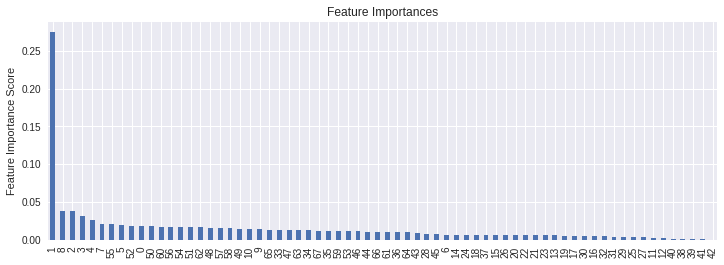

In [82]:
from sklearn.neural_network import MLPClassifier

predictors = [x for x in X_test.columns]
gbm = GradientBoostingClassifier(learning_rate=0.01, 
                                         n_estimators=1500,
                                         max_depth=9, 
                                         min_samples_split=1200, 
                                         min_samples_leaf=60, 
                                         subsample=0.85,
                                         max_features=7)

classifier_report(gbm, X_train, y_train_extension, X_test, y_test_extension, predictors)


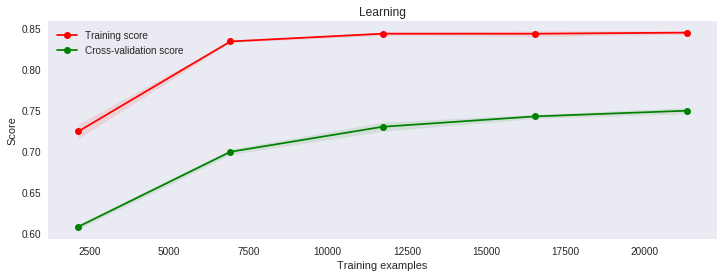

In [83]:
plot_learning_curve(gbm,"Learning", X_train, y_train_extension)


Model Report
Train Accuracy : 0.7873
Test Accuracy : 0.7719
AUC Score (Train): 0.935301
AUC Score (Test): 0.924691
CV Score : Mean - 0.7678126 | Std - 0.002172988 | Min - 0.7656396 | Max - 0.7699856
[[2657  510  241]
 [ 229 1922  123]
 [ 317  405 1596]]


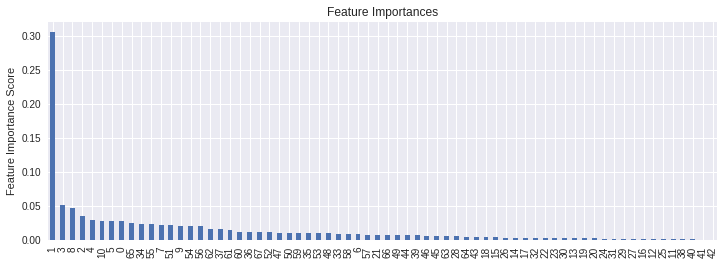

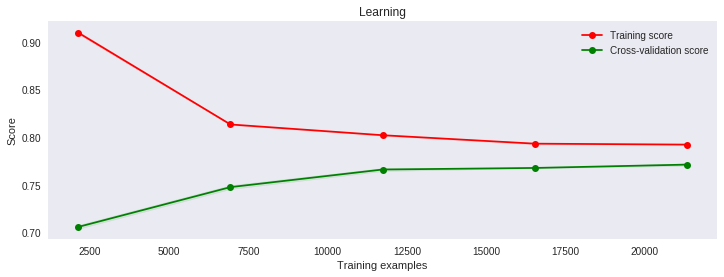

In [84]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=1500, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=1, subsample=0.85, colsample_bytree=1,
                    scale_pos_weight=1)

classifier_report(xgb, X_train, y_train_extension, X_test, y_test_extension, predictors)

plot_learning_curve(xgb,"Learning", X_train, y_train_extension)

In [72]:
X_train, X_test,y_train_acceptance,y_test_acceptance,y_train_extension,y_test_extension = train_test_split(data, y_acceptance, y_extension, test_size=0.30, random_state=10)
X_train_std, X_test_std,y_train_acceptance_std,y_test_acceptance_std,y_train_extension_std,y_test_extension_std = train_test_split(t_data, y_acceptance, y_extension, test_size=0.30, random_state=10)

from sklearn.decomposition import PCA

# on non-standardized data
pca = PCA(n_components=2).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# om standardized data
pca_std = PCA(n_components=2).fit(X_train_std)
X_train_std = pca_std.transform(X_train_std)
X_test_std = pca_std.transform(X_test_std)

In [73]:
X_test_std.shape

(12000, 2)

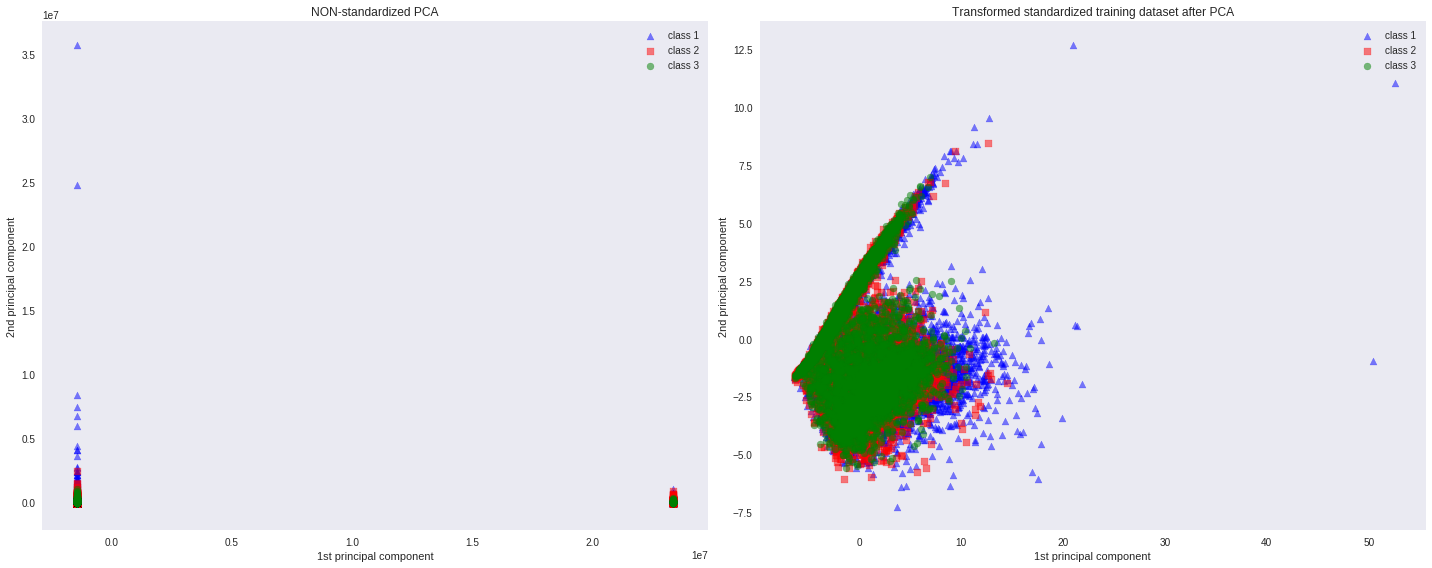

In [74]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))


for l,c,m in zip(range(1,4), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax1.scatter(X_train[y_train_extension==l, 0], X_train[y_train_extension==l, 1],
        color=c,
        label='class %s' %l,
        alpha=0.5,
        marker=m
        )

for l,c,m in zip(range(1,4), ('blue', 'red', 'green'), ('^', 's', 'o')):
    ax2.scatter(X_train_std[y_train_extension_std==l, 0], X_train_std[y_train_extension_std==l, 1],
        color=c,
        label='class %s' %l,
        alpha=0.5,
        marker=m
        )

ax1.set_title('NON-standardized PCA')    
ax2.set_title('Transformed standardized training dataset after PCA')    

for ax in (ax1, ax2):

    ax.set_xlabel('1st principal component')
    ax.set_ylabel('2nd principal component')
    ax.legend(loc='upper right')
    ax.grid()
plt.tight_layout()

plt.show()  

In [ ]:
X_train_std = pd.DataFrame(X_train_std)


from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-2, 10, 4)
gamma_range = np.logspace(-9, 3, 4)

param_grid = dict(gamma=gamma_range, C=C_range)

cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1010)

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)

grid.fit(X_train_std, y_train_extension_std)

In [59]:
grid.score(X_train_std, y_train_extension_std)

0.4231785714285714

In [60]:
grid.score(X_test_std, y_test_extension_std)

0.432